# SVM On Amazon reviews dataset

In [1]:
# importing library
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
#creating new datasets after applying filter on reviews dataset

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
# with the help of this method returning positive and negative based on the score

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape) #looking at the size of the data
filtered_data.head() # top five reviews, just for understanding 

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# delete the reviews which is same on the basis of few features 
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape # after deleting, look at shape again

(364173, 10)

In [5]:
final.head() # look at top five reviews 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# As we know that helfulnessnumerator will not  be greater than helpfullness denominator 
# So we will remove that reviews because that reviews no make sense 

final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
# after removing reviews in above cell which were useless, no make sense
# so look at the reviewsprint(final.shape)
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

# Text preprocessing

In [8]:
# Removing Stop-words

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence):  #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):  #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): # assure that cleaned words are alphabetical and length is greater than 2
                if(cleaned_words.lower() not in stop):  # thos words who were not in stop words
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') # changing cleaned words into lower case
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':  #IF words are positive 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative': # if words are negative
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1) #final_string dataset appending string after cleaning words
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [11]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought sever vital can dog food product found ...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut peanut a...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confect around centuri light pillowi citrus ge...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,look secret ingredi robitussin believ found go...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price wide assort yummi taff...


In [12]:
final.shape # look at the shape of final dataset 

(364171, 11)

In [13]:
# sorting data on the basis of time stamp for time based splitting 
sorted_data=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data

In [14]:
# importing library
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
my_final=final.sample(100000)

# Train test split

In [16]:
# split the data set into train and test
X_tr, X_tes, y_tr, y_test = cross_validation.train_test_split(my_final['CleanedText'].values,my_final['Score'], test_size=0.3, random_state=0)

# SVM On Bag of words

In [17]:
# we are collecting all the words in the form of tokens matrix
count_vect = CountVectorizer(min_df=10) #in scikit-learn
X_train = count_vect.fit_transform(X_tr)#giving training data set to vectorize the training data
X_test = count_vect.transform(X_tes) #giving testing data set to vectorize the testing data
print("the type of count vectorizer ",type(X_train))
print("the shape of out text BOW vectorizer ",X_train.get_shape())
print("the number of unique words ", X_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 7147)
the number of unique words  7147


In [18]:
import warnings
warnings.filterwarnings('ignore')

# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# GridSearchCV with SGDClassifier

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

alpha_range =[{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

grid_search = GridSearchCV(SGDClassifier(loss="hinge", penalty="l2", max_iter=5), param_grid=alpha_range, scoring = 'accuracy', cv=2,n_jobs=-1)
grid_search.fit(X_train_std, y_tr)

print(grid_search.best_estimator_)
print(max(grid_search.cv_results_['mean_train_score']))
print(grid_search.score(X_test_std, y_test))

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.954728560371207
0.9003666666666666


# Error vs alpha

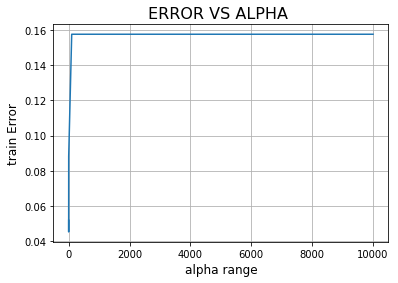

In [20]:
import matplotlib.pyplot as plt
# plot misclassification error vs alpha
MSE = [1 - x for x in grid_search.cv_results_['mean_train_score']]
plt.plot(alpha_range[0]['alpha'], MSE)

plt.xlabel('alpha range',size=12)
plt.ylabel('train Error',size=12)
plt.title('ERROR VS ALPHA ',size=16)
plt.grid()
plt.show()

In [21]:
clf = SGDClassifier(alpha=grid_search.best_params_['alpha'])
clf.fit(X_train_std, y_tr)

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Confusion matrix

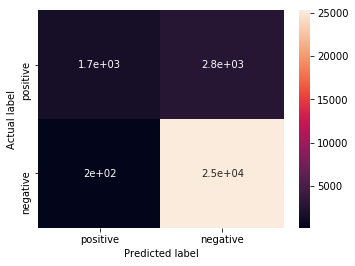

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = clf.predict(X_test_std)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# RandomSearchCV with SGDClassifier

In [23]:
from sklearn.model_selection import RandomizedSearchCV

alpha_range ={'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}

#Using Randomsearch cv
random_search = RandomizedSearchCV(SGDClassifier(loss="hinge", penalty="l2", max_iter=5),alpha_range,scoring='accuracy',cv=2,n_jobs=-1,n_iter=5,pre_dispatch=2)
random_search.fit(X_train_std, y_tr)                                 

print(random_search.best_estimator_)
print(max(random_search.cv_results_['mean_train_score']))
print(random_search.score(X_test_std, y_test))

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9565571015971894
0.9008333333333334


# Error vs alpha

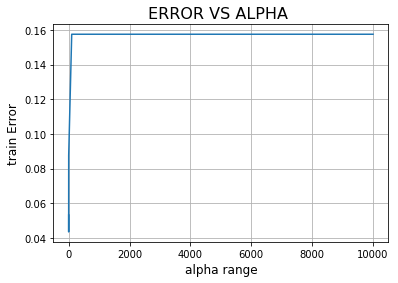

In [24]:
import matplotlib.pyplot as plt
# plot misclassification error vs alpha
MSE = [1 - x for x in random_search.cv_results_['mean_train_score']]
plt.plot(alpha_range['alpha'], MSE)

plt.xlabel('alpha range',size=12)
plt.ylabel('train Error',size=12)
plt.title('ERROR VS ALPHA ',size=16)
plt.grid()
plt.show()

In [25]:
clf = SGDClassifier(alpha=random_search.best_params_['alpha'])
clf.fit(X_train_std, y_tr)

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Confusion matrix

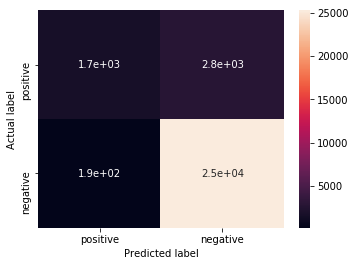

In [26]:
y_pred = clf.predict(X_test_std)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# SVM On tf-idf

In [17]:
# split the data set into train and test
X_tr, X_tes, y_train, y_test = cross_validation.train_test_split(my_final['CleanedText'].values, my_final['Score'], test_size=0.3, random_state=0)

In [18]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
X_train_tfidf = tf_idf_vect.fit_transform(X_tr)
X_test_tfidf=tf_idf_vect.transform(X_tes)

In [19]:
from sklearn.preprocessing import StandardScaler
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_tfidf_std = sc.fit_transform(X_train_tfidf)
X_test_tfidf_std = sc.transform(X_test_tfidf)

# GridsearchCV with SGDClassifier 

In [20]:
from sklearn.svm import SVC   
from sklearn.model_selection import GridSearchCV   
from sklearn.linear_model import SGDClassifier   
      
alpha_range =[{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]   

grid_search = GridSearchCV(SGDClassifier(loss="hinge", penalty="l2", max_iter=5), param_grid=alpha_range, scoring = 'accuracy', cv=2,n_jobs=-1)
grid_search.fit(X_train_tfidf_std, y_train)      

print(grid_search.best_estimator_)          
print(max(grid_search.cv_results_['mean_train_score']))    
print(grid_search.score(X_test_tfidf_std, y_test))     

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9996857142854577
0.9100333333333334


# GridSearchCV with SVC

In [21]:
my_final1=final.sample(20000)

In [22]:
# split the data set into train and test
X_tr, X_tes, y_train, y_test = cross_validation.train_test_split(my_final1['CleanedText'].values, my_final1['Score'], test_size=0.3, random_state=0)

In [23]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
X_train_tfidf = tf_idf_vect.fit_transform(X_tr)
X_test_tfidf=tf_idf_vect.transform(X_tes)

In [24]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_tfidf_std = sc.fit_transform(X_train_tfidf)
X_test_tfidf_std = sc.transform(X_test_tfidf)

In [25]:
from sklearn.svm import SVC  
Cs = [0.001, 0.01, 0.1, 1, 10]  


gammas = [0.001, 0.01, 0.1, 1]  

param_grid = {'C': Cs, 'gamma' : gammas} 
grid_search = GridSearchCV(SVC(), param_grid, cv=2)  
grid_search.fit(X_train_tfidf_std, y_train)  
print(grid_search.best_estimator_)          
print(max(grid_search.cv_results_['mean_train_score']))    
print(grid_search.score(X_test_tfidf_std, y_test)) 


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
1.0
0.8466666666666667


# Error vs alpha

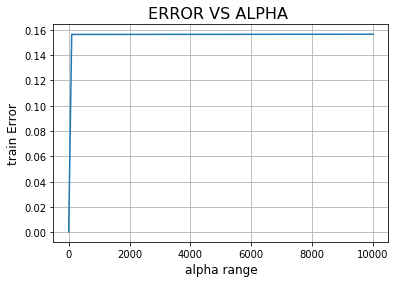

In [113]:

import matplotlib.pyplot as plt
# plot misclassification error vs alpha
MSE = [1 - x for x in grid_search.cv_results_['mean_train_score']]
plt.plot(alpha_range[0]['alpha'], MSE)

plt.xlabel('alpha range',size=12)
plt.ylabel('train Error',size=12)
plt.title('ERROR VS ALPHA ',size=16)
plt.grid()
plt.show()

In [29]:
clf = SGDClassifier(alpha=grid_search.best_params_['alpha'])
clf.fit(X_train_tfidf_std, y_tr)

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Confusion matrix

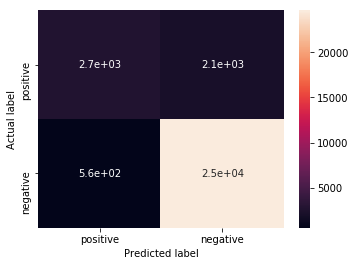

In [30]:
y_pred = clf.predict(X_test_tfidf_std)   

# Creates a confusion matrix   
cm = confusion_matrix(y_test, y_pred)    

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# RandomSearchCV with SGDClassifier

In [114]:
from sklearn.model_selection import RandomizedSearchCV

alpha_range ={'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}

#Using Randomsearch cv
random_search = RandomizedSearchCV(SGDClassifier(loss="hinge", penalty="l2", max_iter=5),alpha_range,scoring='accuracy',cv=2,n_jobs=-1,n_iter=5,pre_dispatch=2)
random_search.fit(X_train_tfidf_std, y_tr)                                 

print(random_search.best_estimator_)
print(max(random_search.cv_results_['mean_train_score']))
print(random_search.score(X_test_tfidf_std, y_test))

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9994714285714286
0.9100666666666667


# Error vs alpha

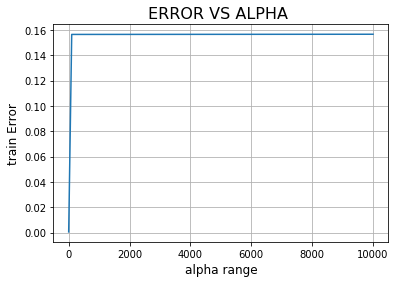

In [115]:
import matplotlib.pyplot as plt
# plot misclassification error vs alpha
MSE = [1 - x for x in random_search.cv_results_['mean_train_score']]
plt.plot(alpha_range['alpha'], MSE)

plt.xlabel('alpha range',size=12)
plt.ylabel('train Error',size=12)
plt.title('ERROR VS ALPHA ',size=16)
plt.grid()
plt.show()

In [32]:
clf = SGDClassifier(alpha=random_search.best_params_['alpha'])
clf.fit(X_train_tfidf_std, y_tr)

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Confusion matrix

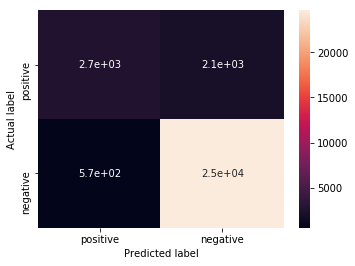

In [33]:
y_pred = clf.predict(X_test_tfidf_std)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# SVM On avgw2v

In [77]:
# split the data set into train and test
X_tr, X_tes, y_train, y_test = cross_validation.train_test_split(my_final['CleanedText'].values, my_final['Score'], test_size=0.3, random_state=0)

In [78]:
#for train data we are finding avg w2v for each train data
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_tr:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)


In [79]:
X_train_avgw2v = []; # the X_train_avgw2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)

In [80]:
#for train data we are finding avg w2v for each train data
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_tes:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [81]:
X_test = []; # the X_train_avgw2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test.append(sent_vec)

In [82]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_avgw2v_vec = sc.fit_transform(X_train_avgw2v)
X_test_avgw2v_vec = sc.transform(X_test)

# GridSearchCV with SGDClassifier

In [116]:
from sklearn.svm import SVC   
from sklearn.model_selection import GridSearchCV   
from sklearn.linear_model import SGDClassifier   
      
alpha_range =[{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]   

grid_search = GridSearchCV(SGDClassifier(loss="hinge", penalty="l2", max_iter=5), param_grid=alpha_range, scoring = 'accuracy', cv=2,n_jobs=-1)
grid_search.fit(X_train_avgw2v_vec, y_train)      

print(grid_search.best_estimator_)          
print(max(grid_search.cv_results_['mean_train_score']))    
print(grid_search.score(X_test_avgw2v_vec, y_test))     

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.8891285714285715
0.8077666666666666


# Error vs alpha

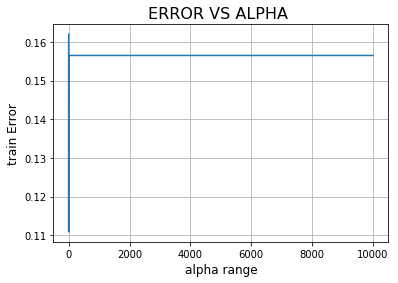

In [117]:
import matplotlib.pyplot as plt
# plot misclassification error vs alpha
MSE = [1 - x for x in grid_search.cv_results_['mean_train_score']]
plt.plot(alpha_range[0]['alpha'], MSE)

plt.xlabel('alpha range',size=12)
plt.ylabel('train Error',size=12)
plt.title('ERROR VS ALPHA ',size=16)
plt.grid()
plt.show()

In [41]:
clf = SGDClassifier(alpha=grid_search.best_params_['alpha'])
clf.fit(X_train_avgw2v_vec, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Confusion matrix

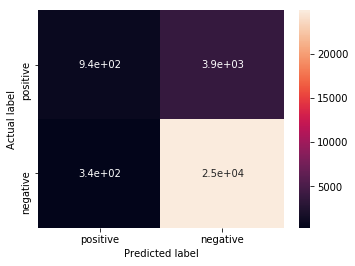

In [42]:
y_pred = clf.predict(X_test_avgw2v_vec)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# RandomSearchCV with SGDClassifier

In [118]:
from sklearn.model_selection import RandomizedSearchCV

alpha_range ={'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}

#Using Randomsearch cv
random_search = RandomizedSearchCV(SGDClassifier(loss="hinge", penalty="l2", max_iter=5),alpha_range,scoring='accuracy',cv=2,n_jobs=-1,n_iter=5,pre_dispatch=2)
random_search.fit(X_train_avgw2v_vec, y_train)                                 

print(random_search.best_estimator_)
print(max(random_search.cv_results_['mean_train_score']))
print(random_search.score(X_test_avgw2v_vec, y_test))

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.8906857142857143
0.8323


# Error vs alpha

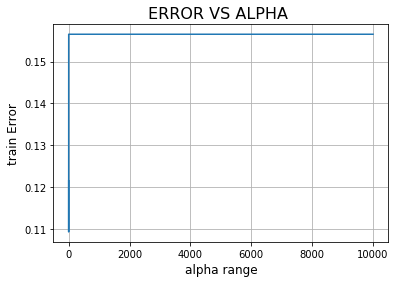

In [119]:
import matplotlib.pyplot as plt
# plot misclassification error vs alpha
MSE = [1 - x for x in random_search.cv_results_['mean_train_score']]
plt.plot(alpha_range['alpha'], MSE)

plt.xlabel('alpha range',size=12)
plt.ylabel('train Error',size=12)
plt.title('ERROR VS ALPHA ',size=16)
plt.grid()
plt.show()

In [44]:
clf = SGDClassifier(alpha=random_search.best_params_['alpha'])
clf.fit(X_train_avgw2v_vec, y_train)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Confusion matrix

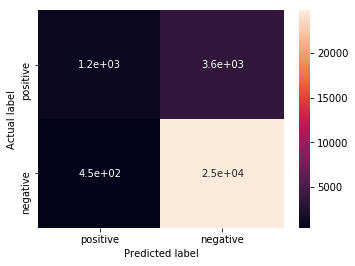

In [45]:
y_pred = clf.predict(X_test_avgw2v_vec)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# SVM on tf-idfw2v

In [87]:
# split the data set into train and test
X_1, X_tes, y_1, y_test = cross_validation.train_test_split(my_final['CleanedText'].values, my_final['Score'], test_size=0.3, random_state=0)

In [88]:
#for train data 
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_1)

In [89]:
# Train your own tfidf Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_1:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [91]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1

In [92]:
#for train data 
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_tes)

In [93]:
# Train your own tfidf Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_tes:
    list_of_sent.append(sent.split())
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [94]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test.append(sent_vec)
    row += 1

In [95]:
# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_tfidfw2v_vec = sc.fit_transform(X_train_tfidfw2v)
X_test_tfidfw2v_vec = sc.transform(X_test)

# GridSearchCV with SGDClassifier

In [120]:
from sklearn.svm import SVC   
from sklearn.model_selection import GridSearchCV   
from sklearn.linear_model import SGDClassifier   
      
alpha_range =[{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]   

grid_search = GridSearchCV(SGDClassifier(loss="hinge", penalty="l2", max_iter=5), param_grid=alpha_range, scoring = 'accuracy', cv=2,n_jobs=-1)
grid_search.fit(X_train_tfidfw2v_vec, y_1)      

print(grid_search.best_estimator_)          
print(max(grid_search.cv_results_['mean_train_score']))    
print(grid_search.score(X_test_tfidfw2v_vec, y_test))     

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.8759142857142858
0.753


# Error vs alpha

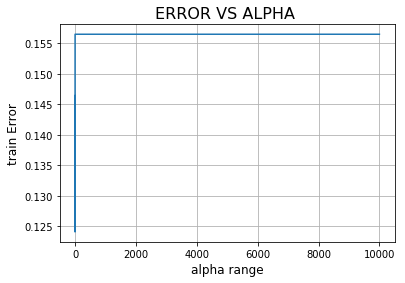

In [121]:
import matplotlib.pyplot as plt
# plot misclassification error vs alpha
MSE = [1 - x for x in grid_search.cv_results_['mean_train_score']]
plt.plot(alpha_range[0]['alpha'], MSE)

plt.xlabel('alpha range',size=12)
plt.ylabel('train Error',size=12)
plt.title('ERROR VS ALPHA ',size=16)
plt.grid()
plt.show()

In [55]:
clf = SGDClassifier(alpha=grid_search.best_params_['alpha'])
clf.fit(X_train_tfidfw2v_vec, y_1)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Confusion matrix

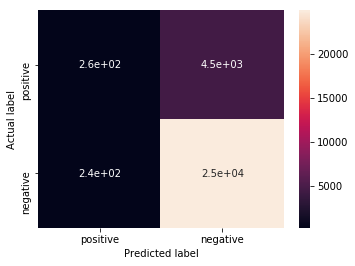

In [56]:
y_pred = clf.predict(X_test_tfidfw2v_vec)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# RandomSearchCV with SGDClassifier

In [122]:
from sklearn.model_selection import RandomizedSearchCV

alpha_range ={'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}

#Using Randomsearch cv
random_search = RandomizedSearchCV(SGDClassifier(loss="hinge", penalty="l2", max_iter=5),alpha_range,scoring='accuracy',cv=2,n_jobs=-1,n_iter=5,pre_dispatch=2)
random_search.fit(X_train_tfidfw2v_vec, y_1)                                 

print(random_search.best_estimator_)
print(max(random_search.cv_results_['mean_train_score']))
print(random_search.score(X_test_tfidfw2v_vec, y_test))

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.8745857142857143
0.7883333333333333


# Error vs alpha

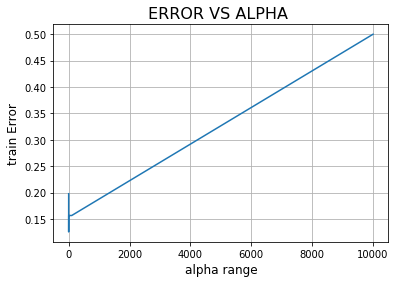

In [123]:
import matplotlib.pyplot as plt
# plot misclassification error vs ALPHA
MSE = [1 - x for x in random_search.cv_results_['mean_train_score']]
plt.plot(alpha_range['alpha'], MSE)

plt.xlabel('alpha range',size=12)
plt.ylabel('train Error',size=12)
plt.title('ERROR VS ALPHA ',size=16)
plt.grid()
plt.show()

In [58]:
clf = SGDClassifier(alpha=random_search.best_params_['alpha'])
clf.fit(X_train_tfidfw2v_vec, y_1)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# Confusion matrix

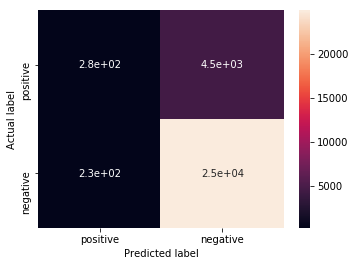

In [59]:
y_pred = clf.predict(X_test_tfidfw2v_vec)

# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['positive','negative'], 
                     columns = ['positive','negative'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# Table with model,hyperparameter,train error and test error

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Optimal alpha", "Train error", "Test error"]

x.add_row(["GRIDSEARCHCV(BOW)", 1,5,11])
x.add_row(["RANDOMSEARCHCV(BOW)", 1,5,11])

x.add_row(["GRIDSEARCHCV(tfidf)", 1,1,9])
x.add_row(["RANDOMSEARCHCV(tfidf)", 1,1,9])

x.add_row(["GRIDSEARCHCV(AVGW2V)", 0.01,12,20])
x.add_row(["RANDOMSEARCHCV(AVGW2V)",0.01,11,17])

x.add_row(["GRIDSEARCHCV(TFIDFW2V)", 0.01,13,25])
x.add_row(["RANDOMSEARCHCV(TFIDFW2V)", 0.01,13,22])


print(x)

+--------------------------+---------------+-------------+------------+
|          Model           | Optimal alpha | Train error | Test error |
+--------------------------+---------------+-------------+------------+
|    GRIDSEARCHCV(BOW)     |       1       |      5      |     11     |
|   RANDOMSEARCHCV(BOW)    |       1       |      5      |     11     |
|   GRIDSEARCHCV(tfidf)    |       1       |      1      |     9      |
|  RANDOMSEARCHCV(tfidf)   |       1       |      1      |     9      |
|   GRIDSEARCHCV(AVGW2V)   |      0.01     |      12     |     20     |
|  RANDOMSEARCHCV(AVGW2V)  |      0.01     |      11     |     17     |
|  GRIDSEARCHCV(TFIDFW2V)  |      0.01     |      13     |     25     |
| RANDOMSEARCHCV(TFIDFW2V) |      0.01     |      13     |     22     |
+--------------------------+---------------+-------------+------------+


# Conclusion

## Procedure Followed:-


STEP 1:- Load the Amazon Fine Food Reviews dataset

STEP 2:- Then we find bag of words then we standarize the data to find optimal alpha.

STEP 3:- Apply GridSearchCV with the help of SGDClassifier and find optimal alpha

STEP 4:- Plot confusion matrix with the help of heatmap and also calculate train error and test error with the optimal alpha

STEP 5:- Apply RandomSearchCV with estimator SGDClassifier and find optimal alpha

STEP 6:- Plot confusion matrix with the help of heatmap and calculate train error and test error

STEP 7:- Then we do the same procedure for tf-idf, avgw2v and tf-idfw2v 
